# Fake News Classifier with RCNN (Model 2)

In [1]:
import io
import json
import random
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_csv('/raid/tft-data/data/combined_news.csv')

# converting labels from strings to ints
data["label"].replace({"Real": 1, "Fake": 0}, inplace=True)

In [3]:
# Tokenizing Data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
max_seq_length = 512 

sequences = tokenizer.texts_to_sequences(data['text'])
padded = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

In [4]:
# Compartmentalizing data into training set and testing set
X = padded
y = data['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Defining and Training the Model 

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 64, input_length=512, trainable=False),
    tf.keras.layers.Conv1D(256, 5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(512, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(768, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_valid, y_valid))

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 64)           8833408   
_________________________________________________________________
conv1d (Conv1D)              (None, 512, 256)          82176     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 256, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 512)          131584    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 768)          393984    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 64, 768)           0

## Visualizing the Results

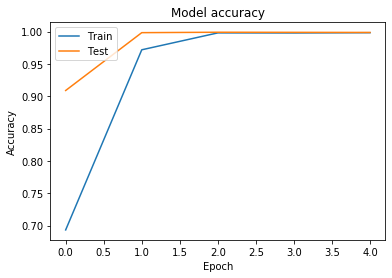

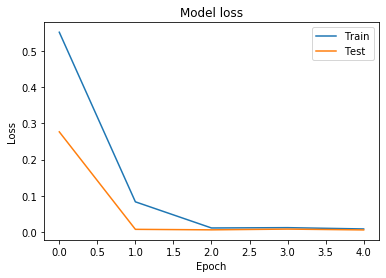

In [6]:
# Repeat for the Second Model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Confusion Matrix 

In [7]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 432x288 with 0 Axes>

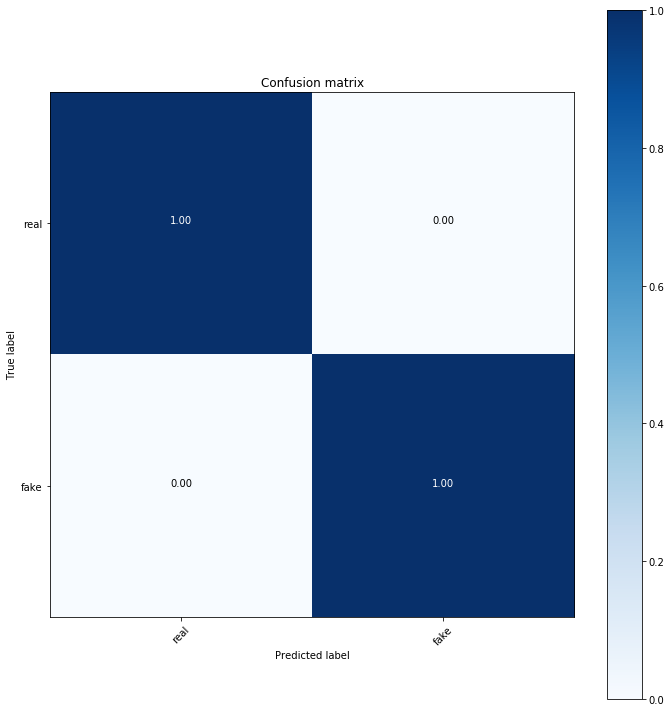

[[3234    0]
 [   9 3043]]


In [8]:
class_names = ['real', 'fake']
# compute confusion matrix
y_pred = model.predict_classes(X_valid)
cnf_matrix = confusion_matrix(y_valid, y_pred)
np.set_printoptions(precision=2)

# plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

print(cnf_matrix)

### Validation Data Results

In [9]:
print('Classification Report:')
print(classification_report(y_valid, y_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.9972    1.0000    0.9986      3234
           1     1.0000    0.9971    0.9985      3052

    accuracy                         0.9986      6286
   macro avg     0.9986    0.9985    0.9986      6286
weighted avg     0.9986    0.9986    0.9986      6286



### Testing Data Results

In [10]:
print('Testing Results:')
y_pred_test = model.predict_classes(X_test)
print(classification_report(y_test, y_pred_test))

Testing Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7091
           1       1.00      1.00      1.00      6379

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



## Exporting the Model

In [11]:
# Save the Tokenizer for this model
tokenizer_json = tokenizer.to_json()
with io.open('rcnn2-tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [12]:
# Save the Model
model.save("rcnn2-model")

INFO:tensorflow:Assets written to: rcnn2-model/assets


INFO:tensorflow:Assets written to: rcnn2-model/assets
